## Homework 8: Supervised, Semi-Supervised, and Unsupervised Learning
### Name: Kayla Hoffman
### Github Username: kaylah176 
### USC ID: 5610859816

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from scipy.special import softmax
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings("ignore")
os.environ['PYTHONWARNINGS'] = 'ignore'

In [13]:
cancer_data_filename = "../Data_HW8/wdbc.data.csv"
banknote_cancer_data_filename = "../Data_HW8/data_banknote_authentication.txt"
summary = {}

In [14]:
df_train = pd.read_csv(cancer_data_filename, header = None)
df_train.replace({'M': 1, 'B': 0}, inplace = True)
df_train.columns = ['id', 'label'] + [f'col{i}' for i in range(1, 31)]
df_train.head()

,id,label,col1,col2,col3,col4,col5,col6,col7,col8,...,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## A) Monte Carlo Simulation 

In [15]:
def split_custom(df_train, random_state, test_size=0.2):
    np.random.seed(random_state)
    # Get indices for each label
    label_0_index = df_train.index[df_train['label'] == 0].to_numpy()
    label_1_index = df_train.index[df_train['label'] == 1].to_numpy()
    
    # Randomly sample test indices for each label
    label_0_test_index = np.random.choice(label_0_index, int(len(label_0_index) * test_size), replace=False)
    label_1_test_index = np.random.choice(label_1_index, int(len(label_1_index) * test_size), replace=False)
    
    # Combine test indices and get train indices by exclusion
    test_index = np.concatenate([label_0_test_index, label_1_test_index])
    train_index = df_train.index.difference(test_index)
    
    # Select features and labels using .loc for clarity
    x_train = df_train.loc[train_index, df_train.columns[2:]].copy()
    y_train = df_train.loc[train_index, 'label'].copy()
    x_test = df_train.loc[test_index, df_train.columns[2:]].copy()
    y_test = df_train.loc[test_index, 'label'].copy()
    
    return x_train, x_test, y_train, y_test

def normalize_data(x_train, x_test):    
    return Normalizer().fit_transform(x_train), Normalizer().fit_transform(x_test)


In [46]:
print(x_train.head)

<bound method NDFrame.head of       col1   col2    col3    col4     col5     col6     col7     col8    col9  \
0    17.99  10.38  122.80  1001.0  0.11840  0.27760  0.30010  0.14710  0.2419   
3    11.42  20.38   77.58   386.1  0.14250  0.28390  0.24140  0.10520  0.2597   
4    20.29  14.34  135.10  1297.0  0.10030  0.13280  0.19800  0.10430  0.1809   
5    12.45  15.70   82.57   477.1  0.12780  0.17000  0.15780  0.08089  0.2087   
6    18.25  19.98  119.60  1040.0  0.09463  0.10900  0.11270  0.07400  0.1794   
..     ...    ...     ...     ...      ...      ...      ...      ...     ...   
563  20.92  25.09  143.00  1347.0  0.10990  0.22360  0.31740  0.14740  0.2149   
564  21.56  22.39  142.00  1479.0  0.11100  0.11590  0.24390  0.13890  0.1726   
565  20.13  28.25  131.20  1261.0  0.09780  0.10340  0.14400  0.09791  0.1752   
566  16.60  28.08  108.30   858.1  0.08455  0.10230  0.09251  0.05302  0.1590   
568   7.76  24.54   47.92   181.0  0.05263  0.04362  0.00000  0.00000  0.1587  

In [16]:
def plot_auc_roc_curve(y_true, y_prob, title, save_path=None):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 5))
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", lw=2, label="Random Guess")
    plt.plot(fpr, tpr, color="#1f77b4", lw=3, label=f"ROC curve (AUC = {roc_auc:.4f})")

    # Highlight the optimal threshold (closest to top-left)
    optimal_idx = ((fpr**2 + (1-tpr)**2).argmin())
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100, label='Best threshold')

    # Annotate important points
    plt.annotate("(0,1)", xy=(0, 1), xytext=(0.1, 0.9), arrowprops=dict(arrowstyle="->"))
    plt.annotate("(1,1)", xy=(1, 1), xytext=(0.8, 0.95), arrowprops=dict(arrowstyle="->"))
    plt.annotate("(0,0)", xy=(0, 0), xytext=(0.1, 0.05), arrowprops=dict(arrowstyle="->"))

    plt.title(f"ROC Curve: {title}\nAUC = {roc_auc:.4f}", fontsize=15)
    plt.xlabel("False Positive Rate", fontsize=13)
    plt.ylabel("True Positive Rate", fontsize=13)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


    
def print_results(y_true, y_pred, y_prob, title):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n=== Analysis Summary for {title} ===")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    plot_auc_roc_curve(y_true, y_prob, title) 

from sklearn.metrics import classification_report, roc_curve, auc

def get_model_summary(model, X, y):
    # Get decision function or probability
    try:
        y_score = model.decision_function(X)
    except AttributeError:
        y_score = model.predict_proba(X)[:, 1]

    y_pred = model.predict(X)
    report = classification_report(y, y_pred, output_dict=True)
    fpr, tpr, _ = roc_curve(y, y_score, pos_label=1)
    roc_auc = auc(fpr, tpr)

    summary = {
        'local_results': {
            'acc': report['accuracy'],
            'precision': report['weighted avg']['precision'],
            'recall': report['weighted avg']['recall'],
            'f1-score': report['weighted avg']['f1-score'],
            'auc': round(roc_auc, 4)
        },
        'predictions': y_pred,
        'probability': y_score,
    }
    return summary


def summarize_results(df_train, df_test):
    summary = pd.DataFrame({
        'training': df_train.mean(),
        'test': df_test.mean()
    }).T
    return summary


### i) Supervised Learning 

In [17]:
def svm_mc(df_train, iters, input_model):
    
    end = 10 if input_model == 'semi-supervised-svm' else 20
    kwargs = {
        'param_grid' : {'C' : np.logspace(-2, 7, end)}, 
        'scoring' : 'f1_weighted',
        'n_jobs' : -1
    }
    
    stats = ['acc', 'precision', 'recall', 'f1-score', 'auc']
    df_train_stats = pd.DataFrame(columns = stats)
    df_test_stats = pd.DataFrame(columns = stats)
    print('Iteration\tTrain Accuracy\tTest Accuracy\tBest Params')
    
    for i in range(iters):
        x_train, x_test, y_train, y_test = split_custom(df_train, i)
        x_train, x_test = normalize_data(x_train, x_test)
        x_train, x_test = pd.DataFrame(x_train), pd.DataFrame(x_test)
        
        if (input_model == 'supervised-svm'):
            kwargs['cv'] = StratifiedKFold(5, random_state = i, shuffle = True)
            model = GridSearchCV(estimator = LinearSVC(penalty = 'l1', dual = False), **kwargs)
            model.fit(x_train, y_train)
        elif (input_model == 'semi-supervised-svm'):
            model = svm_semi_supervised(x_train, y_train, kwargs)
        else:
            model = GridSearchCV(estimator = LinearSVC(penalty = 'l1', dual = False), **kwargs)
            model.fit(x_train, y_train)
            
        stats_train = get_model_summary(model, x_train, y_train)
        stats_test = get_model_summary(model, x_test, y_test)
        df_train_stats = df_train_stats.append(stats_train['local_results'], ignore_index = True)
        df_test_stats = df_test_stats.append(stats_test['local_results'], ignore_index = True)
        acc_train, acc_test = stats_train['local_results']['acc'], stats_test['local_results']['acc']
        print(f'{i + 1}\t\t{round(acc_train, 4)}\t\t{round(acc_test, 4)}\t\t{model.best_params_}')
        
    print_results(y_train, stats_train['predictions'], stats_train['probability'], "Training")
    print_results(y_test, stats_test['predictions'], stats_test['probability'], "Testing")
    summary = summarize_results(df_train_stats, df_test_stats)
    return summary

In [18]:
x_train, x_test, y_train, y_test = split_custom(df_train, 0)

In [19]:
display(y_train.value_counts())
display(y_test.value_counts())

0    286
1    170
Name: label, dtype: int64

0    71
1    42
Name: label, dtype: int64

Iteration	Train Accuracy	Test Accuracy	Best Params
1		0.9956		0.9646		{'C': 127427.49857031321}
2		0.9759		0.9558		{'C': 1623.776739188721}
3		0.9759		0.9204		{'C': 1623.776739188721}
4		0.9825		0.9646		{'C': 4832.930238571752}
5		0.9978		0.9558		{'C': 42813.32398719387}
6		0.9868		0.9469		{'C': 14384.498882876629}
7		0.9781		0.9646		{'C': 14384.498882876629}
8		0.9846		0.9558		{'C': 42813.32398719387}
9		0.9912		0.9735		{'C': 3359818.2862837743}
10		0.9737		1.0		{'C': 4832.930238571752}
11		0.989		0.9292		{'C': 10000000.0}
12		0.9825		0.9912		{'C': 4832.930238571752}
13		0.9803		0.9823		{'C': 4832.930238571752}
14		0.9825		0.9646		{'C': 4832.930238571752}
15		0.9825		0.9558		{'C': 14384.498882876629}
16		0.9912		0.9469		{'C': 14384.498882876629}
17		0.9912		0.9292		{'C': 14384.498882876629}
18		0.9825		0.9823		{'C': 42813.32398719387}
19		0.9737		0.9735		{'C': 14384.498882876629}
20		0.9737		0.9469		{'C': 1623.776739188721}
21		0.9912		0.9646		{'C': 4832.930238571752}
22		0.989		0.973

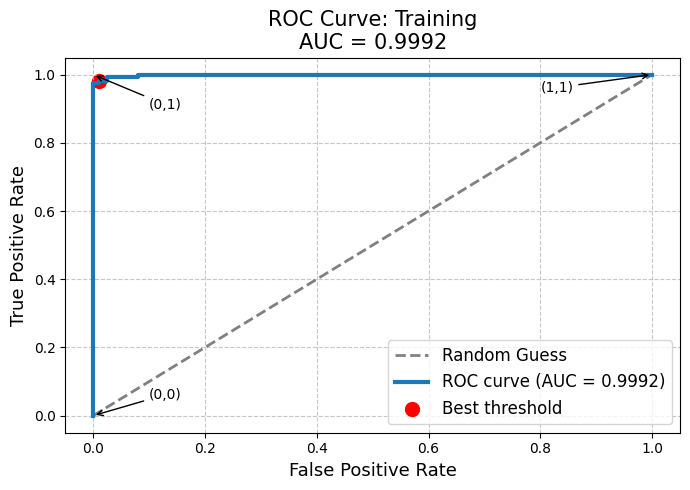


=== Analysis Summary for Testing ===
Accuracy: 0.9469
Confusion Matrix:
[[69  2]
 [ 4 38]]


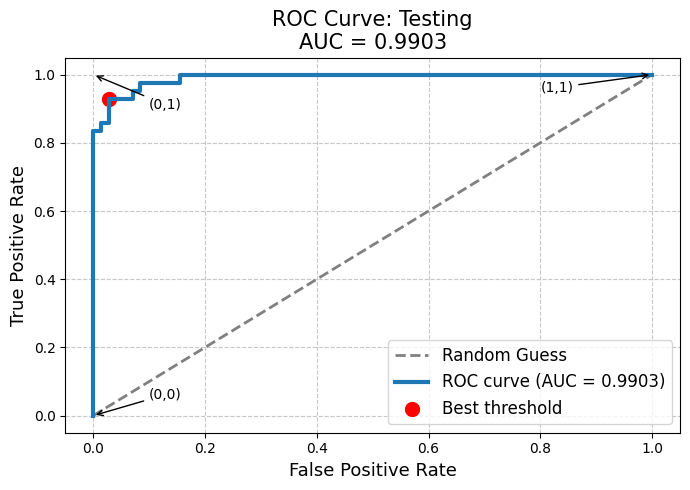

Summarizing Results.....


,acc,precision,recall,f1-score,auc
training,0.983553,0.983585,0.983553,0.983533,0.998597
test,0.958997,0.959415,0.958997,0.958885,0.988433


In [20]:
summary['supervised-svm'] = svm_mc(df_train, 30, 'supervised-svm')
df = pd.DataFrame(summary['supervised-svm'])
print("Summarizing Results.....")
display(df)

## ii) Semi Supervised Learning/ Self Training 

In [21]:
def svm_semi_supervised(x_train, y_train, args):
    labeled_index = []
    unlabeled_index = []
    
    for c in [0, 1]:
        c_label_index, = np.where(y_train == c)
        labeled_index.extend(np.random.choice(c_label_index, round(len(c_label_index) * 0.5), replace = False))
    
    for i in range(len(x_train)):
        if i not in labeled_index:
            unlabeled_index.append(i)

    x_labeled = x_train.iloc[labeled_index].to_numpy().tolist()
    y_labeled = y_train.iloc[labeled_index].to_numpy().tolist()
    x_unlabeled = x_train.iloc[unlabeled_index].to_numpy().tolist()
    y_unlabeled = y_train.iloc[unlabeled_index].to_numpy().tolist()
    
    model = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False), **args)
    model.fit(x_labeled, y_labeled)
    
    while len(x_unlabeled) > 0:
        scores = model.decision_function(x_unlabeled)
        sorted_index = sorted([i for i in range(len(x_unlabeled))], key = lambda x : abs(scores[x]))
        x_unlabeled = [x_unlabeled[i] for i in sorted_index]
        y_unlabeled = [y_unlabeled[i] for i in sorted_index]
        x_labeled.append(x_unlabeled.pop())
        y_labeled.append(y_unlabeled.pop())
        model.best_estimator_.fit(x_labeled, y_labeled) 
    return model

Iteration	Train Accuracy	Test Accuracy	Best Params
1		0.9956		0.9735		{'C': 10000000.0}
2		0.9781		0.9735		{'C': 10000.0}
3		0.989		0.9469		{'C': 10000.0}
4		0.9956		0.9646		{'C': 100000.0}
5		0.989		0.9646		{'C': 10000.0}
6		0.9846		0.9469		{'C': 10000.0}
7		0.9781		0.9646		{'C': 100000.0}
8		0.9846		0.9558		{'C': 100000.0}
9		0.9868		0.9646		{'C': 10000.0}
10		0.9715		1.0		{'C': 10000.0}
11		0.9868		0.9469		{'C': 100000.0}
12		0.989		0.9823		{'C': 100000.0}
13		0.9803		0.9823		{'C': 100000.0}
14		0.989		0.9646		{'C': 10000.0}
15		0.9671		0.9381		{'C': 1000.0}
16		0.9912		0.9381		{'C': 10000.0}
17		0.989		0.9381		{'C': 10000.0}
18		0.9605		0.9735		{'C': 1000.0}
19		0.9825		0.9558		{'C': 100000.0}
20		0.9825		0.9735		{'C': 100000.0}
21		0.9868		0.9646		{'C': 10000.0}
22		0.989		0.9646		{'C': 100000.0}
23		0.9846		0.9558		{'C': 10000000.0}
24		0.9825		0.9381		{'C': 10000.0}
25		0.9715		0.9823		{'C': 10000.0}
26		0.9781		0.9381		{'C': 1000.0}
27		0.9825		0.9558		{'C': 10000.0}
28		0.9715

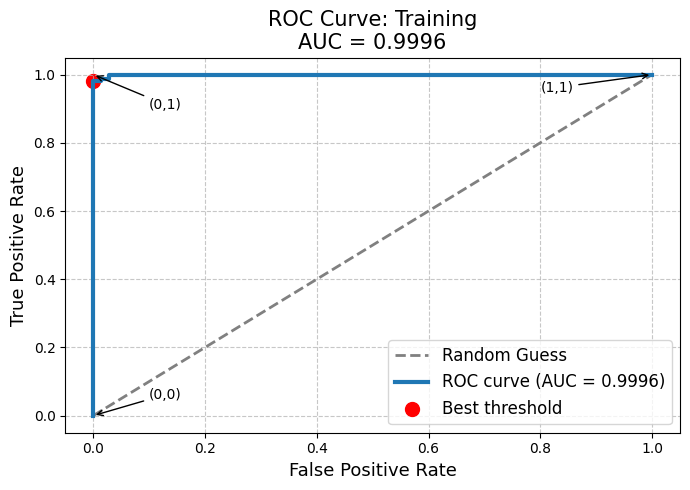


=== Analysis Summary for Testing ===
Accuracy: 0.9381
Confusion Matrix:
[[69  2]
 [ 5 37]]


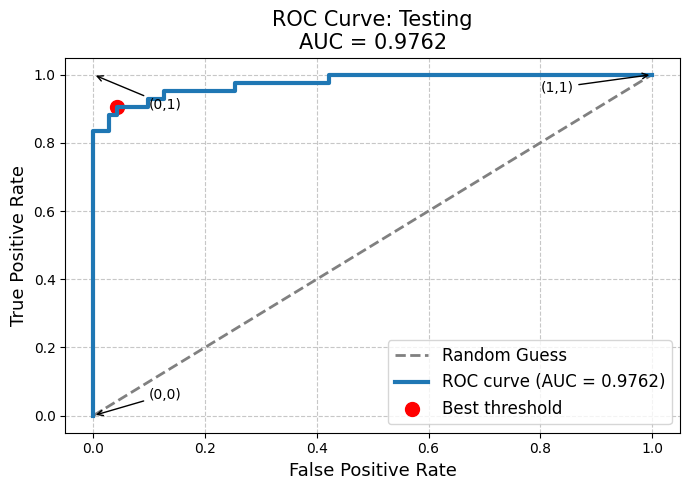

Summarizing Results.....


,acc,precision,recall,f1-score,auc
training,0.983187,0.983208,0.983187,0.983163,0.998620
test,0.959882,0.960334,0.959882,0.959733,0.988247


In [22]:
summary['semi-supervised-svm'] = svm_mc(df_train, 30, 'semi-supervised-svm')
df = pd.DataFrame(summary['semi-supervised-svm'])
print("Summarizing Results.....")
display(df)

## iii) Unsupervised Learning 

Question: How do we make sure that the algorithm is not trapped in a local minimum? 
Answer: We need to set the number of iterations to avoid being trapped in a local minimum. 

In [23]:
def results_summary(true_labels, probability, report):
    # Compute ROC and AUC
    fpr, tpr, _ = roc_curve(true_labels, probability, pos_label=1)
    roc_auc = round(auc(fpr, tpr), 4)
    return {
        'acc': report['accuracy'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score'],
        'auc': roc_auc
    }

def calculate_distance(centers, X, label_cluster):
    n_samples = X.shape[0]
    dist = np.empty(n_samples)
    proba = np.empty((n_samples, 2))
    for i, x in enumerate(X):
        assigned_center = centers[label_cluster[i]]
        dist[i] = np.linalg.norm(x - assigned_center)
        proba[i, 0] = np.linalg.norm(x - centers[0])
        proba[i, 1] = np.linalg.norm(x - centers[1])
    proba = softmax(proba, axis=1).astype(np.float64)
    return dist, proba

def majority_voting(label_cluster, distance, Y, n_points=30):
    label2cluster = np.empty((2,), dtype='int')
    major_label = label_cluster.copy()
    # Support both pandas Series and numpy array for Y
    Y_array = Y.values if hasattr(Y, 'values') else np.array(Y)
    for cluster in [0, 1]:
        sample_index = np.where(label_cluster == cluster)[0]
        # Get the n_points closest samples in this cluster
        top_n = sample_index[np.argsort(distance[sample_index])[:n_points]]
        # Find the majority label
        majority = np.bincount(Y_array[top_n]).argmax()
        major_label[sample_index] = majority
        label2cluster[majority] = cluster
    return label2cluster, major_label

def unsupervised_mc(data, n, input_model):
    stats = ['acc', 'precision', 'recall', 'f1-score', 'auc']
    df_train = pd.DataFrame(columns=stats)
    df_test = pd.DataFrame(columns=stats)
    print('Iteration\tTrain Accuracy\tTest Accuracy')
    
    for i in range(n):
        # Split and normalize data
        x_train, x_test, y_train, y_test = split_custom(data, i)
        x_train, x_test = normalize_data(x_train, x_test)
        
        if input_model == 'unsupervised-kmeans':
            model = KMeans(n_clusters=2, n_init=15, random_state=i).fit(x_train)
            predicted_label = model.predict(x_train)
            cluster_centroid = model.cluster_centers_
        else:
            label_cluster = SpectralClustering(
                n_clusters=2, assign_labels='kmeans', affinity='rbf',
                eigen_tol=1e-2, eigen_solver='arpack', random_state=0
            ).fit_predict(x_train)
            # Compute cluster centroids manually
            cluster_centroid = [
                np.mean(x_train[label_cluster == 0], axis=0),
                np.mean(x_train[label_cluster == 1], axis=0)
            ]
            model = KNeighborsClassifier(n_neighbors=1).fit(x_train, label_cluster)
            predicted_label = model.predict(x_train)
        
        distance, probability = calculate_distance(cluster_centroid, x_train, predicted_label)
        label2cluster, predictions = majority_voting(predicted_label, distance, y_train)
        probability = probability[:, label2cluster[0]]
        model_results = classification_report(y_train, predictions, output_dict=True)
        local_result = results_summary(y_train, probability, model_results)
        df_train = pd.concat([df_train, pd.DataFrame([local_result])], ignore_index=True)
        
        predicted_label_test = model.predict(x_test)
        distance_test, probability_test = calculate_distance(cluster_centroid, x_test, predicted_label_test)
        label2cluster, predictions_test = majority_voting(predicted_label_test, distance_test, y_test)
        probability_test = probability_test[:, label2cluster[0]]
        model_results_test = classification_report(y_test, predictions_test, output_dict=True)
        local_result_test = results_summary(y_test, probability_test, model_results_test)
        df_test = pd.concat([df_test, pd.DataFrame([local_result_test])], ignore_index=True)
        
        acc_train = model_results['accuracy']
        acc_test = model_results_test['accuracy']
        print(f'{i + 1}\t\t{round(acc_train, 4)}\t\t{round(acc_test, 4)}')
    
    print_results(y_train, predictions, probability, 'Training')
    print_results(y_test, predictions_test, probability_test, 'Test')
    summary = summarize_results(df_train, df_test)
    return summary


Iteration	Train Accuracy	Test Accuracy
1		0.8882		0.8761
2		0.8728		0.9558
3		0.8969		0.8496
4		0.886		0.9115
5		0.8991		0.8761
6		0.886		0.8673
7		0.8794		0.8938
8		0.886		0.8673
9		0.8882		0.8584
10		0.8816		0.8938
11		0.8925		0.8761
12		0.8794		0.9115
13		0.8816		0.9027
14		0.8882		0.8938
15		0.8969		0.8496
16		0.8772		0.9027
17		0.9013		0.8319
18		0.8838		0.9115
19		0.886		0.885
20		0.8991		0.8584
21		0.8838		0.9115
22		0.8794		0.8938
23		0.8882		0.885
24		0.8925		0.8496
25		0.8947		0.8761
26		0.8991		0.8407
27		0.8838		0.9027
28		0.886		0.8938
29		0.8904		0.9027
30		0.8925		0.8407

=== Analysis Summary for Training ===
Accuracy: 0.8925
Confusion Matrix:
[[282   4]
 [ 45 125]]


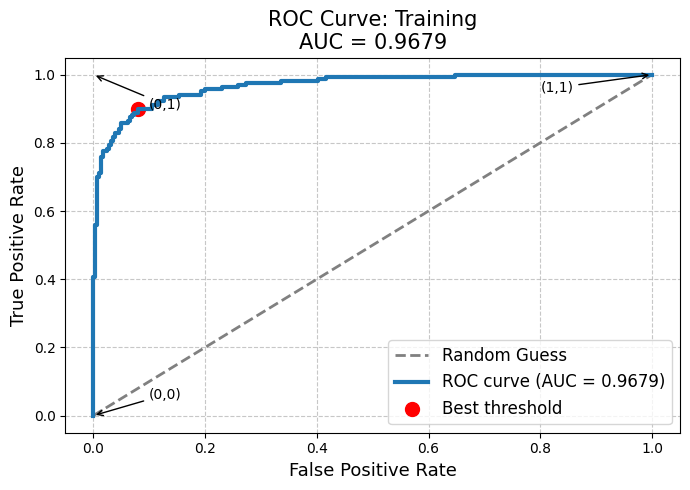


=== Analysis Summary for Test ===
Accuracy: 0.8407
Confusion Matrix:
[[70  1]
 [17 25]]


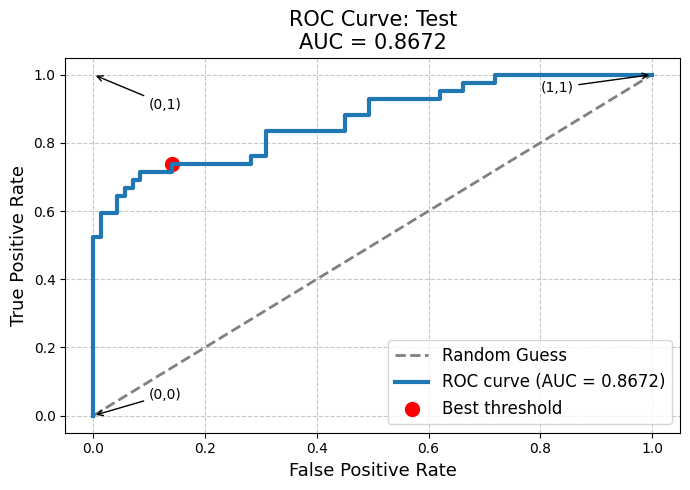

Summarizing Results.....


,acc,precision,recall,f1-score,auc
training,0.888012,0.896900,0.888012,0.884116,0.950737
test,0.882301,0.894138,0.882301,0.877143,0.945920


In [24]:
summary['unsupervised-kmeans'] = unsupervised_mc(df_train, 30, 'unsupervised-kmeans')
df = pd.DataFrame(summary['unsupervised-kmeans'])
print("Summarizing Results.....")
display(df.head())

### iv) Spectral Clustering 

Iteration	Train Accuracy	Test Accuracy
1		0.886		0.885
2		0.8684		0.9204
3		0.8925		0.8407
4		0.8794		0.8761
5		0.8838		0.8761
6		0.8838		0.8761
7		0.8728		0.8938
8		0.8838		0.8496
9		0.886		0.8496
10		0.8772		0.8761
11		0.8904		0.8496
12		0.8794		0.8938
13		0.8794		0.8938
14		0.8794		0.885
15		0.8925		0.8053
16		0.8728		0.885
17		0.8947		0.823
18		0.8816		0.9292
19		0.8838		0.8761
20		0.8925		0.8584
21		0.875		0.9115
22		0.8794		0.885
23		0.8838		0.8761
24		0.8838		0.8496
25		0.8882		0.8496
26		0.8925		0.8407
27		0.8772		0.8938
28		0.8772		0.885
29		0.8772		0.8938
30		0.8925		0.823

=== Analysis Summary for Training ===
Accuracy: 0.8925
Confusion Matrix:
[[282   4]
 [ 45 125]]


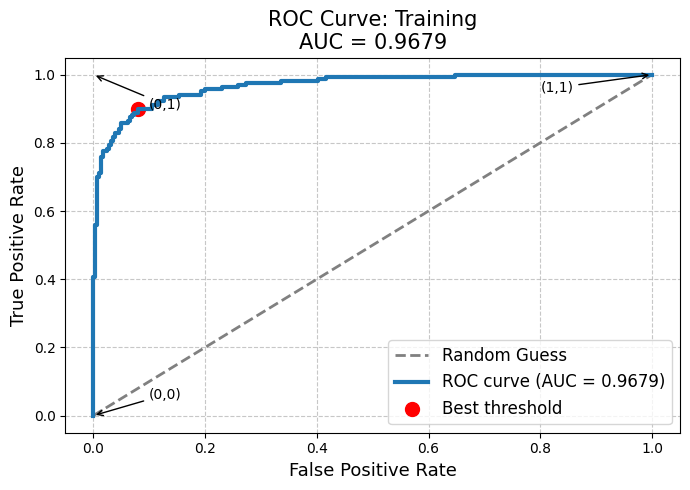


=== Analysis Summary for Test ===
Accuracy: 0.8230
Confusion Matrix:
[[69  2]
 [18 24]]


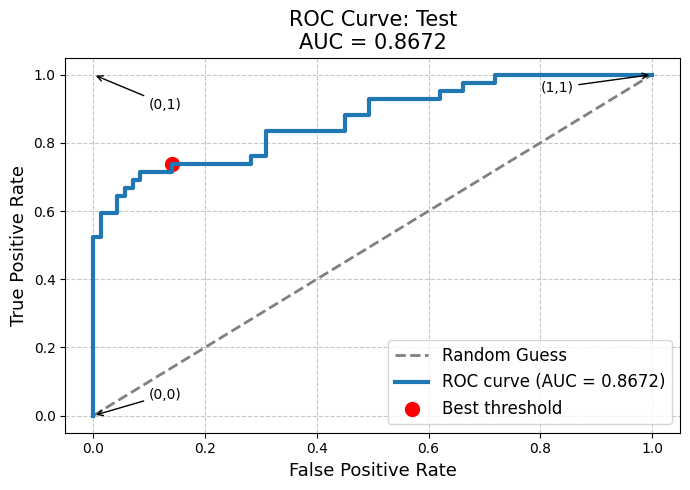

Summarizing Results.....


,acc,precision,recall,f1-score,auc
training,0.882895,0.893003,0.882895,0.878464,0.950147
test,0.871681,0.885106,0.871681,0.865377,0.945257


In [25]:
summary['unsupervised-spectral'] = unsupervised_mc(df_train, 30, 'unsupervised-spectral')
df = pd.DataFrame(summary['unsupervised-spectral'])
print("Summarizing Results.....")
display(df)

In [26]:
for key in summary.keys():
    print('-'*80 + '\n' + key + '\n' + '-'*80 + '\n', summary[key])

--------------------------------------------------------------------------------
supervised-svm
--------------------------------------------------------------------------------
                acc  precision    recall  f1-score       auc
training  0.983553   0.983585  0.983553  0.983533  0.998597
test      0.958997   0.959415  0.958997  0.958885  0.988433
--------------------------------------------------------------------------------
semi-supervised-svm
--------------------------------------------------------------------------------
                acc  precision    recall  f1-score       auc
training  0.983187   0.983208  0.983187  0.983163  0.998620
test      0.959882   0.960334  0.959882  0.959733  0.988247
--------------------------------------------------------------------------------
unsupervised-kmeans
--------------------------------------------------------------------------------
                acc  precision    recall  f1-score       auc
training  0.888012   0.896900  0.888

### Observations 
Ranking which model performed the best: 
1. Supervised SVM
2. Semi-supervised SVM
3. Unsupervised KMeans
4. Unsupervised Spectral 

##### The difference in performance is more prominent between the Supervised SVM's and the Unsupervised Methods because the supervised methods have access to more label information to guide their predictions, whereas the semi-supervised method as less. 

## 2. Active Learning Using Support Vector Machines

In [27]:
df_train = pd.read_csv(banknote_cancer_data_filename, header=None)
df_train.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
df_train.head()
df_train.tail()

,variance,skewness,curtosis,entropy,class
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1
1371,-2.54190,-0.65804,2.6842,1.19520,1


In [49]:
def random_split(df_train):    

    test_index = np.random.choice(df_train.shape[0], 472, replace = False)
    temp_list = []
    for i in range(df_train.shape[0]):
        if i not in test_index:
            temp_list.append(i); 
    train_index = np.array(temp_list)
    x_train = df_train.iloc[train_index]
    x_test = df_train.iloc[test_index]
    return x_train, x_test

x_train, x_test = random_split(df_train)
x_train.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


## Passive Learning

In [52]:
def run_passive_learning(x_train, y_train, x_test, y_test, batch_size=10, C_grid=None, random_state=42):
    if C_grid is None:
        C_grid = {'C': np.logspace(-3, 2, 6)}

    # Shuffle the dataset for randomness
    rng = np.random.RandomState(random_state)
    indices = rng.permutation(len(x_train))
    X_train_shuffled, y_train_shuffled = x_train[indices], y_train[indices]

    n_samples = X_train_shuffled.shape[0]
    train_errors = []
    test_errors = []
    sample_sizes = []

    for end in range(batch_size, n_samples + 1, batch_size):
        X_pool = X_train_shuffled[:end]
        y_pool = y_train_shuffled[:end]

        svc = LinearSVC(penalty='l1', loss='squared_hinge', dual=False, max_iter=10000)
        cv = StratifiedKFold(n_splits=min(5, len(np.unique(y_pool))), shuffle=True, random_state=random_state)
        grid = GridSearchCV(svc, C_grid, cv=cv, scoring='accuracy', n_jobs=-1)
        grid.fit(X_pool, y_pool)

        best_C = grid.best_params_['C']
        final_model = LinearSVC(penalty='l1', loss='squared_hinge', dual=False, C=best_C, max_iter=10000)
        final_model.fit(X_pool, y_pool)

        train_acc = accuracy_score(y_pool, final_model.predict(X_pool))
        test_acc = accuracy_score(y_test, final_model.predict(X_test))
        # print(f"Train accuracy:{train_acc:.3f}, Test accuracy:{test_acc:.3f}")

        train_errors.append(1 - train_acc)
        test_errors.append(1 - test_acc)
        sample_sizes.append(end)

    return test_errors, train_errors, sample_sizes


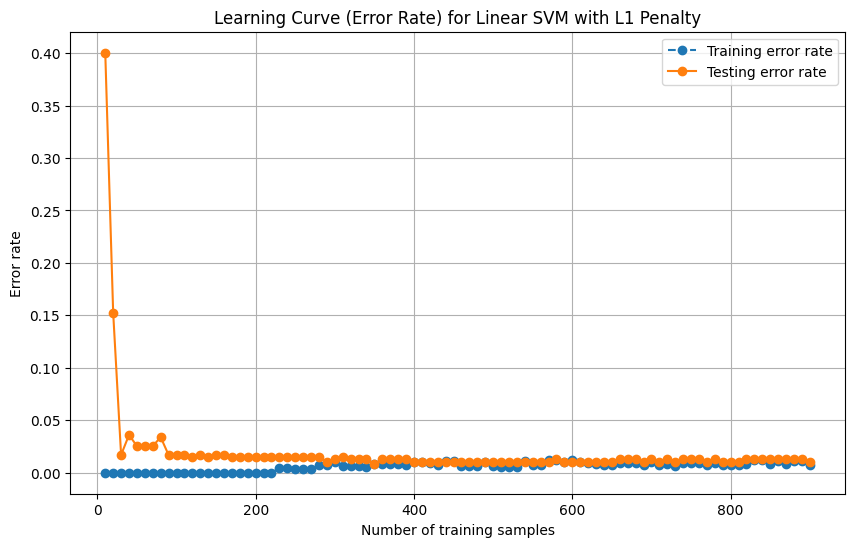

In [53]:
# Correct way:
y_train = x_train['class'].values
X_train = x_train.drop('class', axis=1).values
y_test = x_test['class'].values
X_test = x_test.drop('class', axis=1).values

test_errors, train_errors, sample_sizes = run_passive_learning(X_train, y_train, X_test, y_test)


plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, train_errors, 'o--', label='Training error rate')
plt.plot(sample_sizes, test_errors, 'o-', label='Testing error rate')
plt.xlabel('Number of training samples')
plt.ylabel('Error rate')
plt.title('Learning Curve (Error Rate) for Linear SVM with L1 Penalty')
plt.legend()
plt.grid(True)
plt.show()

## Active Learning 

In [72]:
def run_active_learning(x_train, y_train, x_test, y_test, batch_size=10, initial_pool_size=10, C_grid=None, random_state=42):

    if C_grid is None:
        C_grid = {'C': np.logspace(-3, 2, 6)}

    # Shuffle training data
    rng = np.random.RandomState(random_state)
    indices = rng.permutation(len(x_train))
    X_train, y_train = x_train[indices], y_train[indices]

    # Initialize pools
    X_labeled = X_train[:initial_pool_size]
    y_labeled = y_train[:initial_pool_size]
    X_unlabeled = X_train[initial_pool_size:]
    y_unlabeled = y_train[initial_pool_size:]

    train_errors = []
    test_errors = []
    sample_sizes = []
    train_accs = []  # Use plural for the list

    max_steps = (len(X_train) - initial_pool_size) // batch_size + 1
    for step in range(max_steps):
        svc = LinearSVC(penalty='l1', loss='squared_hinge', dual=False, max_iter=10000)
        cv = StratifiedKFold(n_splits=min(5, len(np.unique(y_labeled))), shuffle=True, random_state=random_state)
        grid = GridSearchCV(svc, C_grid, cv=cv, scoring='accuracy', n_jobs=-1)
        grid.fit(X_labeled, y_labeled)
        best_C = grid.best_params_['C']
        final_model = LinearSVC(penalty='l1', loss='squared_hinge', dual=False, C=best_C, max_iter=10000)
        final_model.fit(X_labeled, y_labeled)

        train_acc = accuracy_score(y_labeled, final_model.predict(X_labeled))
        test_acc = accuracy_score(y_test, final_model.predict(X_test))
        train_accs.append(train_acc)

        train_errors.append(1 - train_acc)
        test_errors.append(1 - test_acc)
        sample_sizes.append(len(X_labeled))
        train_accs.append(train_acc)  # Append to the list

        current_batch_size = min(batch_size, len(X_unlabeled))
        if current_batch_size == 0:
            break

        decisions = final_model.decision_function(X_unlabeled)
        uncertainty_scores = np.abs(decisions)
        query_indices = np.argpartition(uncertainty_scores, current_batch_size - 1)[:current_batch_size]

        X_labeled = np.vstack([X_labeled, X_unlabeled[query_indices]])
        y_labeled = np.concatenate([y_labeled, y_unlabeled[query_indices]])
        X_unlabeled = np.delete(X_unlabeled, query_indices, axis=0)
        y_unlabeled = np.delete(y_unlabeled, query_indices, axis=0)

    return test_errors, train_errors, sample_sizes, train_accs


In [76]:
test_errors, train_errors, sample_sizes, train_accs = run_active_learning(X_train, y_train, X_test, y_test)
print(f"Training accuracy: {np.mean(train_accs)}")


Training accuracy: 0.9781516752958663


In [77]:
# Check for label in features
print("Label in features:", 'label' in x_train.columns)

# Check for overlap in indices
train_indices = set(x_train.index)
test_indices = set(x_test.index)
print("Overlap in indices:", len(train_indices & test_indices))

# Check class distribution
print("Train class distribution:", np.bincount(y_train))
print("Test class distribution:", np.bincount(y_test))


Label in features: False
Overlap in indices: 0
Train class distribution: [510 390]
Test class distribution: [252 220]


In [78]:
# If you have indices
train_indices = set(x_train.index)
test_indices = set(x_test.index)
print("Overlap in indices:", len(train_indices & test_indices))  # Should be 0


Overlap in indices: 0


In [79]:
print("Sample sizes length:", len(sample_sizes))  # Should be 90
print("Test errors length:", len(test_errors))    # Should match sample_sizes
print("Train errors length:", len(train_errors))  # Should match sample_sizes


Sample sizes length: 90
Test errors length: 90
Train errors length: 90


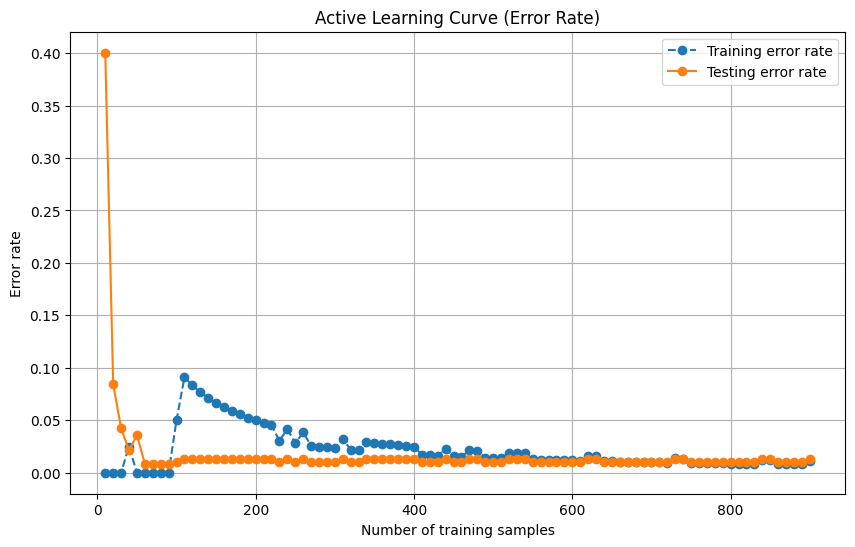

In [80]:
# Plot error rates
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, train_errors, 'o--', label='Training error rate')
plt.plot(sample_sizes, test_errors, 'o-', label='Testing error rate')
plt.xlabel('Number of training samples')
plt.ylabel('Error rate')
plt.legend()
plt.title('Active Learning Curve (Error Rate)')
plt.grid(True)
plt.show()

## Monte Carlo Simulation

#### Monte Carlo Simulation for Active Learning 

In [84]:
n_simulations = 50
batch_size = 10
initial_pool_size = 10
test_size = 472

all_test_errors = []
all_train_errors = []

# For padding results to the same length
n_train = len(df_train) - test_size
max_steps = (n_train - initial_pool_size) // batch_size + 1

for sim in range(n_simulations):
    # Split data randomly for each run
    test_index = np.random.choice(df_train.shape[0], test_size, replace=False)
    train_index = [i for i in range(df_train.shape[0]) if i not in test_index]
    x_train = df_train.iloc[train_index]
    x_test = df_train.iloc[test_index]

    y_train = x_train['class'].values
    X_train = x_train.drop('class', axis=1).values
    y_test = x_test['class'].values
    X_test = x_test.drop('class', axis=1).values

    # Run active learning
    test_errors, train_errors, sample_sizes, train_accs = run_active_learning(
        X_train, y_train, X_test, y_test,
        batch_size=batch_size,
        initial_pool_size=initial_pool_size, C_grid=None,
        random_state=sim
    )

    # Pad to max_steps with np.nan if needed
    if len(test_errors) < max_steps:
        test_errors += [np.nan] * (max_steps - len(test_errors))
        train_errors += [np.nan] * (max_steps - len(train_errors))
    all_test_errors.append(test_errors)
    all_train_errors.append(train_errors)

all_test_errors = np.array(all_test_errors)
all_train_errors = np.array(all_train_errors)
sample_sizes = np.arange(initial_pool_size, initial_pool_size + batch_size*max_steps, batch_size)

np.savez('active_learning_mc_results.npz',
         all_test_errors=all_test_errors,
         all_train_errors=all_train_errors,
         sample_sizes=sample_sizes)



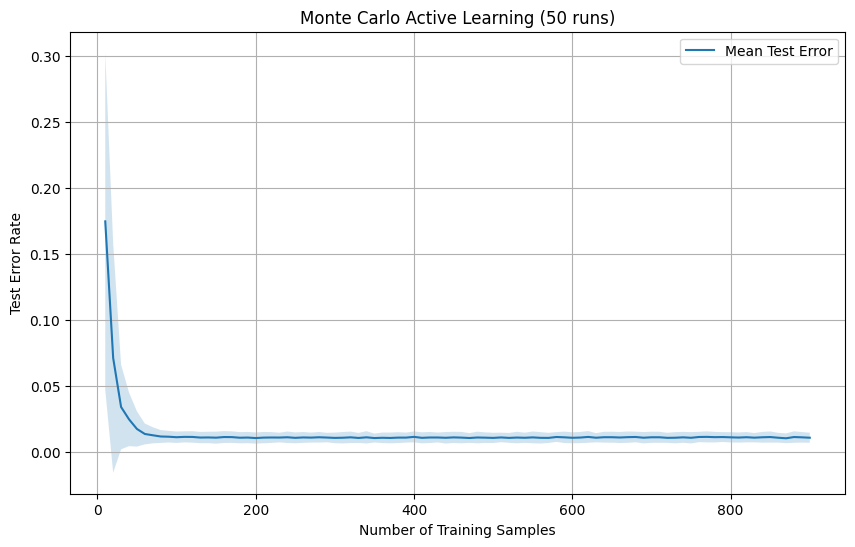

In [85]:
mean_test_errors = np.nanmean(all_test_errors, axis=0)
std_test_errors = np.nanstd(all_test_errors, axis=0)

plt.figure(figsize=(10,6))
plt.plot(sample_sizes, mean_test_errors, label='Mean Test Error')
plt.fill_between(sample_sizes, mean_test_errors-std_test_errors, mean_test_errors+std_test_errors, alpha=0.2)
plt.xlabel('Number of Training Samples')
plt.ylabel('Test Error Rate')
plt.title('Monte Carlo Active Learning (50 runs)')
plt.legend()
plt.grid(True)
plt.show()

### Monte Carlo Simulation for Passive Learning

In [86]:
n_simulations = 50
batch_size = 10
test_size = 472
C_grid = {'C': np.logspace(-3, 2, 6)}

all_test_errors = []
all_train_errors = []

n_train = len(df_train) - test_size
max_steps = n_train // batch_size

for sim in range(n_simulations):
    # Random split
    test_index = np.random.choice(df_train.shape[0], test_size, replace=False)
    train_index = [i for i in range(df_train.shape[0]) if i not in test_index]
    x_train = df_train.iloc[train_index]
    x_test = df_train.iloc[test_index]

    y_train = x_train['class'].values
    X_train = x_train.drop('class', axis=1).values
    y_test = x_test['class'].values
    X_test = x_test.drop('class', axis=1).values

    # Run passive learning
    test_errors, train_errors, sample_sizes = run_passive_learning(
        X_train, y_train, X_test, y_test,
        batch_size=batch_size,
        C_grid=C_grid,
        random_state=sim
    )

    # Pad if needed
    if len(test_errors) < max_steps:
        test_errors += [np.nan] * (max_steps - len(test_errors))
        train_errors += [np.nan] * (max_steps - len(train_errors))
    all_test_errors.append(test_errors)
    all_train_errors.append(train_errors)

all_test_errors = np.array(all_test_errors)
all_train_errors = np.array(all_train_errors)
sample_sizes = np.arange(batch_size, batch_size * (max_steps + 1), batch_size)

np.savez('passive_learning_mc_results.npz',
         all_test_errors=all_test_errors,
         all_train_errors=all_train_errors,
         sample_sizes=sample_sizes)



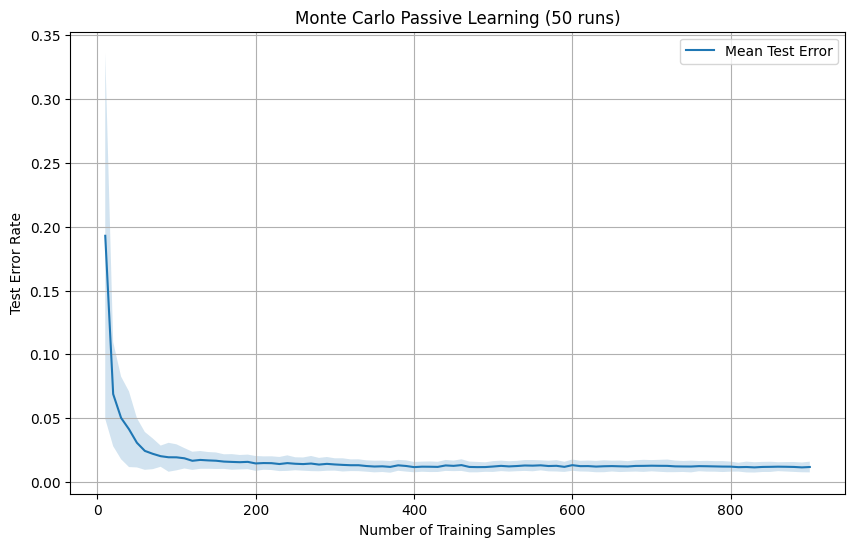

In [87]:
mean_test_errors = np.nanmean(all_test_errors, axis=0)
std_test_errors = np.nanstd(all_test_errors, axis=0)

plt.figure(figsize=(10,6))
plt.plot(sample_sizes, mean_test_errors, label='Mean Test Error')
plt.fill_between(sample_sizes, mean_test_errors-std_test_errors, mean_test_errors+std_test_errors, alpha=0.2)
plt.xlabel('Number of Training Samples')
plt.ylabel('Test Error Rate')
plt.title('Monte Carlo Passive Learning (50 runs)')
plt.legend()
plt.grid(True)
plt.show()

## Joint Plot of Active vs Passive Learning Monte Carlo Simulations

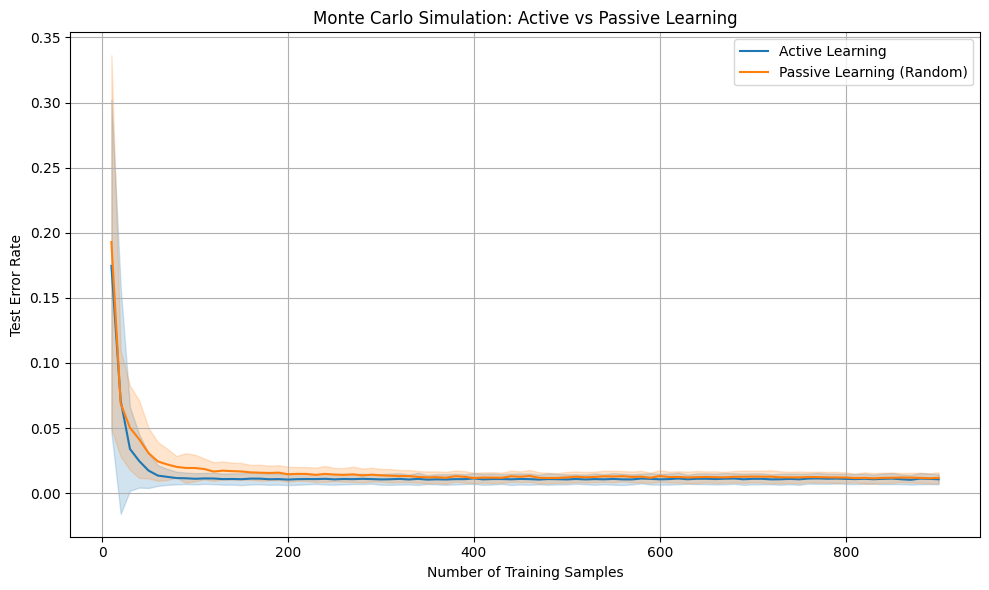

In [88]:
# Load results (if saved)
active = np.load('active_learning_mc_results.npz')
passive = np.load('passive_learning_mc_results.npz')

all_test_errors_active = active['all_test_errors']
sample_sizes_active = active['sample_sizes']

all_test_errors_passive = passive['all_test_errors']
sample_sizes_passive = passive['sample_sizes']

# Calculate mean and std (ignore NaNs)
mean_active = np.nanmean(all_test_errors_active, axis=0)
std_active = np.nanstd(all_test_errors_active, axis=0)

mean_passive = np.nanmean(all_test_errors_passive, axis=0)
std_passive = np.nanstd(all_test_errors_passive, axis=0)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes_active, mean_active, label='Active Learning', color='tab:blue')
plt.fill_between(sample_sizes_active, mean_active-std_active, mean_active+std_active, color='tab:blue', alpha=0.2)

plt.plot(sample_sizes_passive, mean_passive, label='Passive Learning (Random)', color='tab:orange')
plt.fill_between(sample_sizes_passive, mean_passive-std_passive, mean_passive+std_passive, color='tab:orange', alpha=0.2)

plt.xlabel('Number of Training Samples')
plt.ylabel('Test Error Rate')
plt.title('Monte Carlo Simulation: Active vs Passive Learning')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
